In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import time
from scipy.signal import convolve2d
from sklearn.preprocessing import StandardScaler
%matplotlib notebook

In [2]:
dim = 9;
step = 0.67;
nn = (dim+1)/2;
G0 = np.zeros((dim,dim));
H0 = np.zeros((dim,dim));
G90 = np.zeros((dim,dim));
H90 = np.zeros((dim,dim));
for i in range(dim):
    for j in range(dim):
        
        x=(i-nn + 1)*step
        y=(j-nn + 1)*step
        
        G0[j,i]=0.9213*(2*x**2-1)*np.exp(-x**2-y**2)
        G90[j,i]=0.9213*(2*y**2-1)*np.exp(-x**2-y**2)
        
        H0[j,i]=(-2.205*x+0.9780*x**3)*np.exp(-x**2-y**2)
        H90[j,i]=(-2.205*y+0.9780*y**3)*np.exp(-x**2-y**2)
        

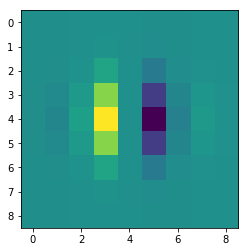

In [3]:
plt.imshow(H0)

In [4]:
files = os.listdir("Data/")
print(files)

['bad.MOV', 'Baseline.MOV', 'damage168.MOV', 'damage84.MOV', 'Damaged.MOV', 'good.MOV', 'nodamage.MOV']


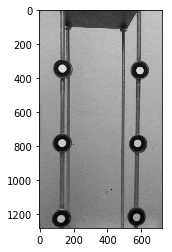

In [5]:
video_path = ["Data/Baseline.MOV","Data/Damaged.MOV"]

cap = cv2.VideoCapture(video_path[0])
ret, frame = cap.read()
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
frame = cv2.transpose(frame)
plt.imshow(frame, cmap = 'gray')

In [6]:
r = cv2.selectROI(frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

(511.0, 710.0, 142.0, 146.0)


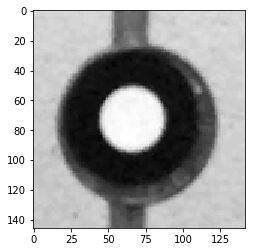

In [7]:
print(r)
sub_frame = frame[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
plt.imshow(sub_frame, cmap = 'gray')

In [8]:
def PME(video_name,r ,G ,H ,total_time):
    cap = cv2.VideoCapture(video_name)
    signal = []
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    ret, old_frame = cap.read()
    
    old_frame = cv2.cvtColor(old_frame,cv2.COLOR_BGR2GRAY)
    old_frame = cv2.transpose(old_frame)
    old_frame = old_frame[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
    
    C_old = convolve2d(old_frame, G, 'valid') + 1j*convolve2d(old_frame, H, 'valid')
    
    phi1 = np.angle(C_old)
    amp1 = np.abs(C_old)

    for i in range(total_time * fps):
        
        ret, new_frame = cap.read()
        
        new_frame = cv2.cvtColor(new_frame,cv2.COLOR_BGR2GRAY)
        new_frame = cv2.transpose(new_frame)
        new_frame = new_frame[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
        
        C_new = convolve2d(new_frame, G, 'valid') + 1j*convolve2d(new_frame, H, 'valid')
        
        
        phi2 = np.angle(C_new)
        amp2 = np.abs(C_new)
        
        avg_amp = (amp1 + amp2)/2
        
        PHI = np.zeros((phi1.shape[0], phi1.shape[1],2))
    
        PHI[:,:,0] = phi1
        PHI[:,:,1] = phi2
        PHI = np.unwrap(PHI, axis=2)

    
        delta_phi = PHI[:,:,1] - PHI[:,:,0]
        
        motion = np.mean((avg_amp * delta_phi)/np.sum(avg_amp))
        signal.append(motion)
        phi1 = phi2
        amp1 = amp2
    
    
    return signal

In [9]:

baseline = PME(video_path[0], r ,G0 ,H0 ,10)
damaged = PME(video_path[1], r ,G0 ,H0 ,10)


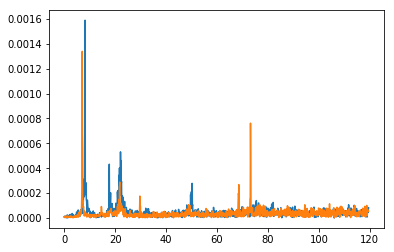

In [10]:
N = len(baseline) # number of sample points
Ts = 1.0/239 # Sampling frequency
xf = np.linspace(0.0, 1.0/(2.0 * Ts), N//2)

ybaseline = np.fft.fft(baseline)
ydamaged = np.fft.fft(damaged)

abs_baseline = np.abs(ybaseline[:N//2])
abs_damaged = np.abs(ydamaged[:N//2])



fig, axs = plt.subplots()
axs.plot(xf, abs_baseline)
axs.plot(xf, abs_damaged)

In [11]:
def get_feature(video_name, r ,G ,H ,total_time, time_ratio):
    
    feature = []
    cap = cv2.VideoCapture(video_name)
    
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    
    
    
    for j in range(int(frameCount * time_ratio/(total_time * fps))):
        print(j)
        signal = []
        ret, old_frame = cap.read()
        old_frame = cv2.cvtColor(old_frame,cv2.COLOR_BGR2GRAY)
        old_frame = cv2.transpose(old_frame)
        old_frame = old_frame[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]

        C_old = convolve2d(old_frame, G, 'valid') + 1j*convolve2d(old_frame, H, 'valid')

        phi1 = np.angle(C_old)
        amp1 = np.abs(C_old)

        for i in range(total_time * fps):

            ret, new_frame = cap.read()

            new_frame = cv2.cvtColor(new_frame,cv2.COLOR_BGR2GRAY)
            new_frame = cv2.transpose(new_frame)
            new_frame = new_frame[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]

            C_new = convolve2d(new_frame, G, 'valid') + 1j*convolve2d(new_frame, H, 'valid')


            phi2 = np.angle(C_new)
            amp2 = np.abs(C_new)

            avg_amp = (amp1 + amp2)/2

            PHI = np.zeros((phi1.shape[0], phi1.shape[1],2))

            PHI[:,:,0] = phi1
            PHI[:,:,1] = phi2
            PHI = np.unwrap(PHI, axis=2)


            delta_phi = PHI[:,:,1] - PHI[:,:,0]

            motion = np.mean((avg_amp * delta_phi)/np.sum(avg_amp))
            signal.append(motion)
            
            phi1 = phi2
            amp1 = amp2
            
        FFT = np.fft.fft(signal)
        N = len(signal)
        feature.append(np.abs(FFT[:N//2]))
        
    
    return np.array(feature)

In [12]:
features = get_feature(video_path[0], r ,G0 ,H0 ,1, 0.05)

0
1
2
3
4
5
6
7
8


In [13]:
def get_all_features(video_list, r ,G ,H ,total_time, time_ratio):
    
    Y = []
    all_features = []
    
    for item in video_list:
        print(item)
        video_name = item
        
        features = get_feature(video_name, r ,G ,H ,total_time, time_ratio)
        
        for i in range(len(features)):
            if(item == video_list[0]):
                Y.append(0)
            else:
                Y.append(1)
        
    
        all_features.append(features)
    
    X = np.vstack(all_features).astype(np.float64)
    
    return X,Y 

In [14]:
X,Y = get_all_features(video_path, r ,G0 ,H0 ,1, 0.9)

Data/Baseline.MOV
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
Data/Damaged.MOV
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
1

In [ ]:
print(X.shape)
print(Y)

In [ ]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = rand_state)

In [ ]:
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [ ]:
# Train a Support Vector Machine (SVM)
rbf_svc = SVC(kernel='rbf')

t0 = time.time()
rbf_svc.fit(X_train, y_train)
t1 = time.time()

delta_t =t1 - t0
print(delta_t)

In [ ]:
print(rbf_svc.score(X_test,y_test))